In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Dropout, Lambda
from keras.losses import Loss
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv('processed_marginal_data_with_year_scaled.csv')

# Define input and output sequence lengths
sequence_length = 336  # Use 2 weeks of history for predictions
output_sequence_length = 24  # Predict the next 24 hours

# Prepare the input features and target prices
X, y = [], []
for i in range(len(data) - sequence_length - output_sequence_length):
    features = data[['Price1', 'Hour_Sin', 'Hour_Cos', 'Day_Sin','Day_Cos' ,'Month_Sin','Month_Cos','Year_Scaled']].values
    X.append(features[i:i + sequence_length])  # Input sequence
    y.append(features[i + sequence_length:i + sequence_length + output_sequence_length, 0])  # Output sequence of prices

X = np.array(X)  # Shape: (samples, sequence_length, features)
y = np.array(y)  # Shape: (samples, output_sequence_length)

# Normalize data
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_shape = X.shape
X = scaler_X.fit_transform(X.reshape(-1, X.shape[2])).reshape(X_shape)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(y)

# Reshape y to match model's output shape: (samples, output_sequence_length, 1)
y = y.reshape((y.shape[0], y.shape[1], 1))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Define a custom loss for the normal distribution
class NLLGaussian(Loss):
    def call(self, y_true, y_pred):
        mean = y_pred[:, :, 0]
        std_dev = y_pred[:, :, 1]

        # Clamp std_dev to avoid excessive uncertainty
        std_dev = tf.clip_by_value(std_dev, clip_value_min=1e-3, clip_value_max=0.3)

        # Weighted mean squared error term
        mse_term = tf.square(y_true[:, :, 0] - mean) / tf.square(std_dev)
        
        # Adjusted NLL loss with higher weight on MSE
        nll_loss = 0.5 * tf.math.log(2 * np.pi * tf.square(std_dev)) + 0.7 * mse_term
        return tf.reduce_mean(nll_loss)

# Build the LSTM model with a single LSTM layer and dropout
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
    Dropout(0.2),
    # Slice the output to only get the last `output_sequence_length` steps
    Lambda(lambda x: x[:, -output_sequence_length:, :]),
    TimeDistributed(Dense(units=2))
])

# Compile the model with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=NLLGaussian())

# Train the model
epochs = 50
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss:.6f}')
print(f'Test Loss: {test_loss:.6f}')

: 

In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Dropout, Lambda
import tensorflow as tf

# Parameters
sequence_length = 336  # Use 2 weeks of history
output_sequence_length = 24  # Predict the next 24 hours
batch_size = 32

# Load the preprocessed data
data_file = "processed_marginal_data_with_year_scaled.csv"
data = pd.read_csv(data_file)

# Define a generator to yield batches from the single CSV file
def data_generator(data, sequence_length, output_sequence_length, batch_size):
    total_samples = len(data) - sequence_length - output_sequence_length
    while True:  # Infinite loop for training
        for start_idx in range(0, total_samples, batch_size):
            X_batch, y_batch = [], []
            for i in range(start_idx, min(start_idx + batch_size, total_samples)):
                # Create sequences
                features = data[['Price1', 'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos', 'Year_Scaled']].values
                X_batch.append(features[i:i + sequence_length])
                y_batch.append(features[i + sequence_length:i + sequence_length + output_sequence_length, 0])  # Predict Price1
            
            X_batch = np.array(X_batch)
            y_batch = np.array(y_batch).reshape((len(X_batch), output_sequence_length, 1))

            # Normalize batch
            scaler_X = MinMaxScaler(feature_range=(0, 1))
            X_shape = X_batch.shape
            X_batch = scaler_X.fit_transform(X_batch.reshape(-1, X_batch.shape[2])).reshape(X_shape)

            scaler_y = MinMaxScaler(feature_range=(0, 1))
            y_batch = scaler_y.fit_transform(y_batch.reshape(-1, 1)).reshape((len(X_batch), output_sequence_length, 1))

            yield X_batch, y_batch

# Split data into training and testing
train_size = int(len(data) * 0.7)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

train_gen = data_generator(train_data, sequence_length, output_sequence_length, batch_size)
test_gen = data_generator(test_data, sequence_length, output_sequence_length, batch_size)

# Estimate steps per epoch
steps_per_epoch = len(train_data) // batch_size
validation_steps = len(test_data) // batch_size

# Define the LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 8)),
    Dropout(0.2),
    # Slice the output to only get the last `output_sequence_length` steps
    Lambda(lambda x: x[:, -output_sequence_length:, :]),
    TimeDistributed(Dense(units=1))
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Train the model
epochs = 10  # Adjust epochs as needed
history = model.fit(
    train_gen,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_gen,
    validation_steps=validation_steps
)

# Evaluate the model
test_loss = model.evaluate(test_gen, steps=validation_steps)
print(f"Test Loss: {test_loss:.6f}")


Epoch 1/10


/home/teitur/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - loss: 0.1288 - val_loss: 0.1071
Epoch 2/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 52s 54ms/step - loss: 0.1062 - val_loss: 0.1030
Epoch 3/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - loss: 0.1028 - val_loss: 0.0988
Epoch 4/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 37s 39ms/step - loss: 0.1026 - val_loss: 0.0985
Epoch 5/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - loss: 0.1022 - val_loss: 0.0989
Epoch 6/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - loss: 0.1014 - val_loss: 0.0983
Epoch 7/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - loss: 0.1017 - val_loss: 0.0984
Epoch 8/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - loss: 0.0992 - val_loss: 0.0988
Epoch 9/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 34s 35ms/step - loss: 0.0991 - val_loss: 0.0981
Epoch 10/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - loss: 0.0988 - val_loss: 0.0979
410/410 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0983
Test Loss: 0.097960


In [38]:
print(model.summary())

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 336, 50)        │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 336, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_14 (Lambda)              │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 24, 1)          │            51 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,555 (138.89 KB)

 Trainable params: 11,851 (46.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,704 (92.60 KB)

None


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


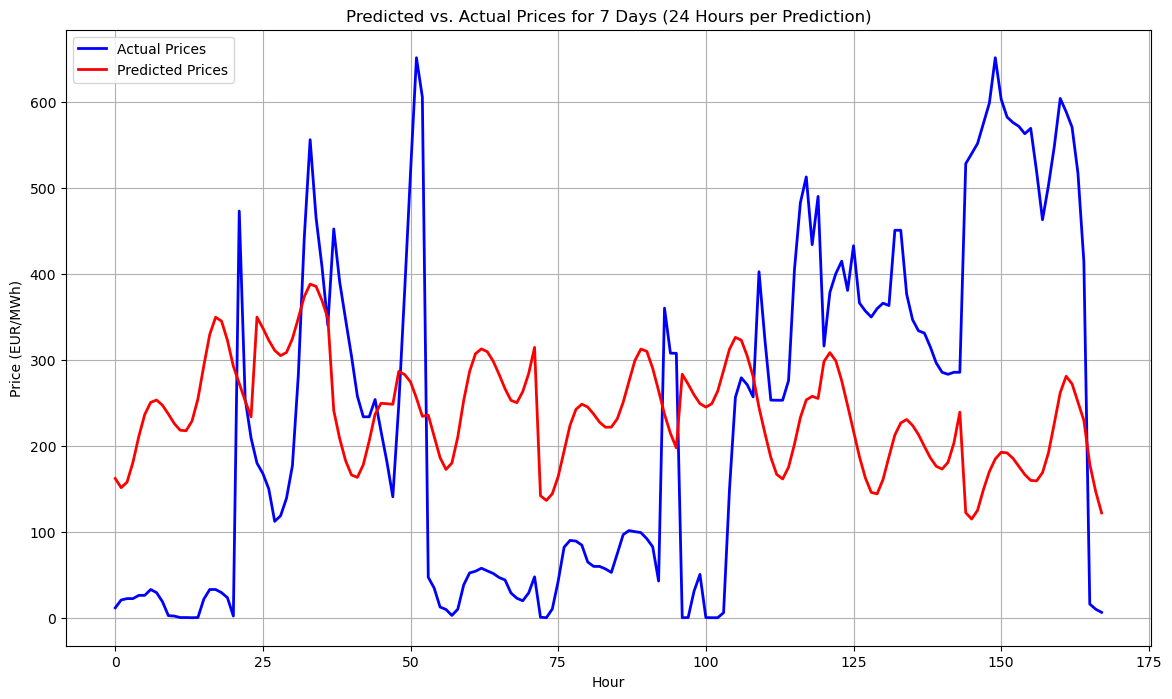

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Extract multiple batches for a week (7 sequences of 24 hours each)
num_days = 7
predictions = []
actuals = []

for _ in range(num_days):
    # Get a batch from the test generator
    X_test_batch, y_test_batch = next(test_gen)
    
    # Predict prices for the batch
    y_test_pred = model.predict(X_test_batch)
    
    # Reshape predictions and actual values for storage
    predictions.append(y_test_pred[0].flatten())  # Take the first sample in the batch
    actuals.append(y_test_batch[0].flatten())     # Take the corresponding actual values

# Combine predictions and actuals into single arrays
predicted_prices = np.concatenate(predictions)
actual_prices = np.concatenate(actuals)

# Inverse transform the scaled predictions and actuals to get real prices
predicted_prices_actual = scaler_target.inverse_transform(predicted_prices.reshape(-1, 1)).flatten()
actual_prices_actual = scaler_target.inverse_transform(actual_prices.reshape(-1, 1)).flatten()

# Plot the extended predictions vs. actual prices
plt.figure(figsize=(14, 8))
time_steps = range(len(predicted_prices_actual))

# Plot actual prices
plt.plot(time_steps, actual_prices_actual, label="Actual Prices", color="blue", linewidth=2)

# Plot predicted prices
plt.plot(time_steps, predicted_prices_actual, label="Predicted Prices", color="red", linewidth=2)

# Customize the plot
plt.title("Predicted vs. Actual Prices for 7 Days (24 Hours per Prediction)")
plt.xlabel("Hour")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Ensure scaler_y is fitted on a 1D column only
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_y.fit(y.reshape(-1, 1))

# Predict on test data
y_test_pred = model.predict(X_test)

# Separate predictions into mean and standard deviation
predicted_means = y_test_pred[:, :, 0]
predicted_std_devs = y_test_pred[:, :, 1]

# Reshape to 2D (flattened) for inverse transformation
predicted_means_flat = predicted_means.reshape(-1, 1)
y_test_actual_flat = y_test.reshape(-1, 1)

# Apply inverse transform and reshape back to original shape
predicted_means = scaler_y.inverse_transform(predicted_means_flat).reshape(predicted_means.shape)
y_test_actual = scaler_y.inverse_transform(y_test_actual_flat).reshape(y_test.shape)

# Number of samples to visualize
num_samples = 1  # Adjust this value to see more/less samples

plt.figure(figsize=(15, num_samples * 4))

for i in range(num_samples):
    plt.subplot(num_samples, 1, i + 1)
    time_steps = range(output_sequence_length)
    
    # Plot actual prices
    plt.plot(time_steps, y_test_actual[i], label="Actual Prices", color="blue", linewidth=2)

    # Plot predicted mean prices
    plt.plot(time_steps, predicted_means[i], label="Predicted Mean", color="red", linewidth=2)


    # Customize the plot
    plt.title(f"Sample {i + 1}: Predicted vs. Actual Prices with Confidence Intervals")
    plt.xlabel("Hour")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


NameError: name 'y' is not defined

In [17]:
import requests
import pandas as pd
from datetime import datetime

# Define the API endpoint
BASE_URL = "https://archive-api.open-meteo.com/v1/archive"

# Define coordinates for key regions in Spain
locations = [
    {"name": "Madrid", "lat": 40.4168, "lon": -3.7038},
    {"name": "Barcelona", "lat": 41.3851, "lon": 2.1734},
    {"name": "Seville", "lat": 37.3891, "lon": -5.9845},
    {"name": "Valencia", "lat": 39.4699, "lon": -0.3763},
    {"name": "Bilbao", "lat": 43.2630, "lon": -2.9350},
    {"name": "A Coruña", "lat": 43.3623, "lon": -8.4115},
    {"name": "Badajoz", "lat": 38.8794, "lon": -6.9707},
]

# Define the weather parameters to fetch
PARAMETERS = "temperature_2m,precipitation,wind_speed_10m,cloudcover,shortwave_radiation"

# Define the time range
START_YEAR = 2018
END_YEAR = 2023

# Initialize an empty list to store data for all locations
all_weather_data = []

# Loop through each location and fetch data
for location in locations:
    print(f"Fetching data for {location['name']}...")
    
    # Initialize a DataFrame for this location
    location_weather_data = pd.DataFrame()
    
    # Fetch data for each year
    for year in range(START_YEAR, END_YEAR + 1):
        start_date = f"{year}-01-01"
        end_date = f"{year}-12-31"
        
        # Make the API request
        response = requests.get(
            BASE_URL,
            params={
                "latitude": location["lat"],
                "longitude": location["lon"],
                "start_date": start_date,
                "end_date": end_date,
                "hourly": PARAMETERS,
                "timezone": "auto"
            },
        )
        
        if response.status_code == 200:
            # Parse the response JSON
            data = response.json()
            hourly_data = pd.DataFrame(data["hourly"])
            
            # Add a location column and merge data
            hourly_data["location"] = location["name"]
            hourly_data["time"] = pd.to_datetime(hourly_data["time"])
            location_weather_data = pd.concat([location_weather_data, hourly_data], ignore_index=True)
        else:
            print(f"Failed to fetch data for {year} at {location['name']}: {response.status_code}")
            print(response.text)

    # Append this location's data to the main list
    all_weather_data.append(location_weather_data)

# Combine all location data into a single DataFrame
final_weather_data = pd.concat(all_weather_data, ignore_index=True)

# Save to CSV
output_file = "spain_weather_data_2018_2023.csv"
final_weather_data.to_csv(output_file, index=False)
print(f"Data saved to {output_file}")

# Display a preview of the data
print(final_weather_data.head())


Fetching data for Madrid...
Fetching data for Barcelona...
Fetching data for Seville...
Fetching data for Valencia...
Fetching data for Bilbao...
Fetching data for A Coruña...
Fetching data for Badajoz...
Data saved to spain_weather_data_2018_2023.csv
                 time  temperature_2m  precipitation  wind_speed_10m  \
0 2018-01-01 00:00:00             4.9            0.0            16.2   
1 2018-01-01 01:00:00             4.3            0.0            14.5   
2 2018-01-01 02:00:00             4.4            0.0            13.0   
3 2018-01-01 03:00:00             4.3            0.0            13.0   
4 2018-01-01 04:00:00             3.6            0.0            11.3   

   cloudcover  shortwave_radiation location  
0           0                  0.0   Madrid  
1           0                  0.0   Madrid  
2           0                  0.0   Madrid  
3           1                  0.0   Madrid  
4           0                  0.0   Madrid  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Dropout, Lambda
from keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

# Parameters
sequence_length = 336  # Use 2 weeks of history
output_sequence_length = 24  # Predict the next 24 hours
batch_size = 32
epochs = 10

# Load the preprocessed data with Gas_Price included
data_file = "/home/teitur/DTU/electricproject/deeplearning/model/data_weather_gas.csv"
data = pd.read_csv(data_file)

# **Check for Missing or Infinite Values**
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

# Normalize the entire dataset (features and target)
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

# Include Gas_Price in the features
features = data[['Price1', 'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Month_Sin', 
                 'Month_Cos', 'Year_Scaled', 'temperature_2m', 'precipitation', 
                 'wind_speed_10m', 'Gas_Price']]
target = data[['Price1']]

# Scale the features and target
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target)

# Append scaled features and target back to the DataFrame
data_scaled = pd.DataFrame(features_scaled, columns=features.columns)
data_scaled['Price1'] = target_scaled

# Define a generator to yield batches from the single CSV file
def data_generator(data, sequence_length, output_sequence_length, batch_size):
    total_samples = len(data) - sequence_length - output_sequence_length
    while True:  # Infinite loop for training
        for start_idx in range(0, total_samples, batch_size):
            X_batch, y_batch = [], []
            for i in range(start_idx, min(start_idx + batch_size, total_samples)):
                # Create sequences
                features = data[['Price1', 'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 
                                 'Month_Sin', 'Month_Cos', 'Year_Scaled', 'temperature_2m', 
                                 'precipitation', 'wind_speed_10m', 'Gas_Price']].values
                X_batch.append(features[i:i + sequence_length])
                y_batch.append(features[i + sequence_length:i + sequence_length + output_sequence_length, 0])  # Predict Price1
            
            X_batch = np.array(X_batch)
            y_batch = np.array(y_batch).reshape((len(X_batch), output_sequence_length, 1))

            yield X_batch, y_batch

# Split data into training and testing
train_size = int(len(data_scaled) * 0.7)
train_data = data_scaled.iloc[:train_size]
test_data = data_scaled.iloc[train_size:]

train_gen = data_generator(train_data, sequence_length, output_sequence_length, batch_size)
test_gen = data_generator(test_data, sequence_length, output_sequence_length, batch_size)

# Estimate steps per epoch
steps_per_epoch = len(train_data) // batch_size
validation_steps = len(test_data) // batch_size

# Define the LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 12)),  # 12 input features (including Gas_Price)
    Dropout(0.2),
    # Slice the output to only get the last `output_sequence_length` steps
    Lambda(lambda x: x[:, -output_sequence_length:, :]),
    TimeDistributed(Dense(units=1))
])

# Compile the model with gradient clipping
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse')

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_gen,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_gen,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

# Save the model
model.save('lstm_energy_price_model.h5')

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model
test_loss = model.evaluate(test_gen, steps=validation_steps)
print(f"Test Loss: {test_loss:.6f}")

# Test predictions
test_samples = next(test_gen)
X_test, y_true = test_samples[0], test_samples[1]
y_pred = model.predict(X_test)

# Plot the first prediction vs. true values
plt.plot(y_true[0], label='True Prices')
plt.plot(y_pred[0].squeeze(), label='Predicted Prices')
plt.legend()
plt.title('Predicted vs True Energy Prices')
plt.show()


/home/teitur/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Input 0 of layer "lstm_21" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 336)

Predicting and collecting data for visualization...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Plotting predictions vs. actual prices...


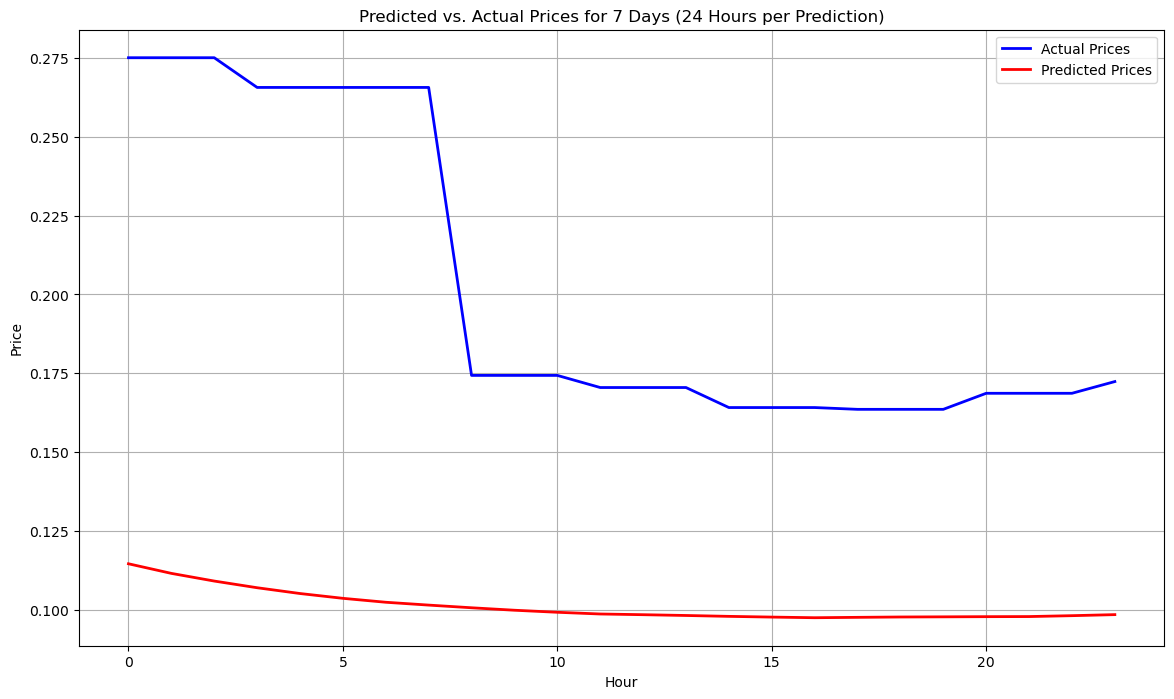

Mean Absolute Error (MAE): 0.10
Mean Squared Error (MSE): 0.01


In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure the model and test_gen are available and configured
if "test_gen" not in globals():
    raise ValueError("The test generator (test_gen) is not defined.")

if "model" not in globals():
    raise ValueError("The trained model is not available.")

# Parameters for visualization
num_days = 1  # Visualize predictions for 7 days
output_sequence_length = 24  # Hours predicted in each sequence
batch_size = 32  # Batch size used during training

# Initialize arrays to store predictions and actuals
predictions = []
actuals = []

# Extract and predict for 7 sequences of 24 hours each
print("Predicting and collecting data for visualization...")
for _ in range(num_days):
    try:
        # Get a batch from the test generator
        X_test_batch, y_test_batch = next(test_gen)

        # Predict prices for the batch
        y_test_pred = model.predict(X_test_batch)

        # Append the first prediction and actual values from the batch
        predictions.append(y_test_pred[0].flatten())  # First sample in batch
        actuals.append(y_test_batch[0].flatten())     # Corresponding actual values
    except StopIteration:
        print("End of test generator reached.")
        break

# Combine predictions and actual values into single arrays
predicted_prices = np.concatenate(predictions)
actual_prices = np.concatenate(actuals)

# Debug: Check if arrays have valid values
if np.isnan(predicted_prices).any() or np.isnan(actual_prices).any():
    print("Warning: Predicted or actual prices contain NaN values. Check the model or data.")

# Plot the extended predictions vs. actual prices
print("Plotting predictions vs. actual prices...")
plt.figure(figsize=(14, 8))
time_steps = range(len(predicted_prices))

# Plot actual prices
plt.plot(time_steps, actual_prices, label="Actual Prices", color="blue", linewidth=2)

# Plot predicted prices
plt.plot(time_steps, predicted_prices, label="Predicted Prices", color="red", linewidth=2)

# Customize the plot
plt.title("Predicted vs. Actual Prices for 7 Days (24 Hours per Prediction)")
plt.xlabel("Hour")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Debug: Calculate and print basic metrics for comparison
mae = np.mean(np.abs(predicted_prices - actual_prices))
print(f"Mean Absolute Error (MAE): {mae:.2f}")

mse = np.mean((predicted_prices - actual_prices) ** 2)
print(f"Mean Squared Error (MSE): {mse:.2f}")


Total Rows: 51221
Missing Rows: 69 (0.13%)

Missing Data Analysis:
Are missing rows sequential? Yes
Are missing values clustered? Yes

Missing Patterns by Year and Month:
   Decoded_Year  Decoded_Month  Missing_Days_Count
0          2019              7                  23
1          2020              5                  46

Missing patterns have been saved to 'missing_gas_price_patterns.csv'.


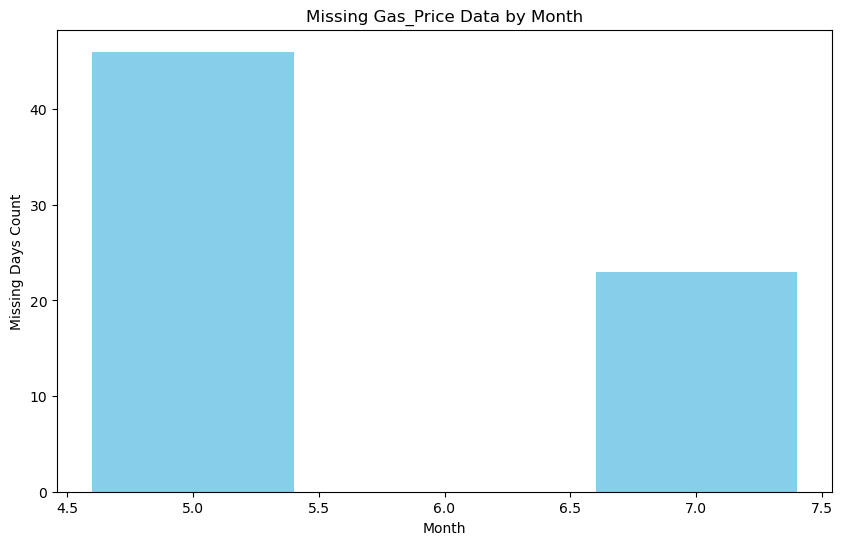

In [22]:
import pandas as pd
import numpy as np

# Load the data
data_file = "data_weather_gas.csv"  # Update this to your file path
data = pd.read_csv(data_file)

# Decode sinusoidal and cosine values to retrieve Month and Day information
def decode_time(sin_val, cos_val, max_value):
    angle = np.arctan2(sin_val, cos_val)
    if angle < 0:
        angle += 2 * np.pi
    return int(round((angle / (2 * np.pi)) * max_value))

# Add decoded Month and Day to the dataset
data['Decoded_Month'] = data.apply(lambda row: decode_time(row['Month_Sin'], row['Month_Cos'], 12), axis=1)
data['Decoded_Day'] = data.apply(lambda row: decode_time(row['Day_Sin'], row['Day_Cos'], 31), axis=1)

# Handle Year_Scaled to recover Year
base_year = 2018  # Assuming 2018 is the base year for scaling
data['Decoded_Year'] = (data['Year_Scaled'] * 10).round().astype(int) + base_year - 1

# Identify rows with missing `Gas_Price`
missing_gas_price = data[data['Gas_Price'].isnull()].copy()

# Check the percentage of missing rows
total_rows = len(data)
missing_rows = len(missing_gas_price)
missing_percentage = (missing_rows / total_rows) * 100
print(f"Total Rows: {total_rows}")
print(f"Missing Rows: {missing_rows} ({missing_percentage:.2f}%)")

# Check if missing rows are sequential
missing_gas_price['Is_Sequential'] = (
    (missing_gas_price['Decoded_Year'].diff() == 0) &
    (missing_gas_price['Decoded_Month'].diff() == 0) &
    (missing_gas_price['Decoded_Day'].diff().isin([0, 1]))  # Same day or consecutive days
)

# Group by Year, Month, and Day to detect patterns
missing_patterns = missing_gas_price.groupby(['Decoded_Year', 'Decoded_Month']).size().reset_index(name='Missing_Days_Count')

# Check if there are clusters of missing values
clustered_days = missing_gas_price.groupby(['Decoded_Year', 'Decoded_Month', 'Decoded_Day']).size()
is_clustered = (clustered_days > 1).sum() > 0

# Print analysis
print("\nMissing Data Analysis:")
print(f"Are missing rows sequential? {'Yes' if missing_gas_price['Is_Sequential'].any() else 'No'}")
print(f"Are missing values clustered? {'Yes' if is_clustered else 'No'}")

# Print missing patterns by year and month
print("\nMissing Patterns by Year and Month:")
print(missing_patterns)

# Save the missing pattern report
missing_patterns.to_csv("missing_gas_price_patterns.csv", index=False)
print("\nMissing patterns have been saved to 'missing_gas_price_patterns.csv'.")

# Visualization (optional)
try:
    import matplotlib.pyplot as plt

    # Visualize missing days per month
    plt.figure(figsize=(10, 6))
    plt.bar(missing_patterns['Decoded_Month'], missing_patterns['Missing_Days_Count'], color='skyblue')
    plt.xlabel('Month')
    plt.ylabel('Missing Days Count')
    plt.title('Missing Gas_Price Data by Month')
    plt.show()
except ImportError:
    print("\nMatplotlib not installed. Skipping visualization.")


In [14]:
import os
import pandas as pd

# Directory containing the downloaded XLSX files
input_dir = "/home/teitur/DTU/electricproject/deeplearning/gas/"  # Update this path
output_dir = "/home/teitur/DTU/electricproject/deeplearning/gas/output/csv"  # Update this path
os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists

# Specify the target sheet name or index
target_sheet = "Regulated gas"  # Replace with the name of the desired sheet (or use its index, e.g., 0)

# Loop through all XLSX files in the input directory
for file_name in os.listdir(input_dir):
    if file_name.endswith(".xlsx"):  # Process only XLSX files
        input_path = os.path.join(input_dir, file_name)
        print(f"Processing file: {file_name}")
        
        try:
            # Load the target sheet into a DataFrame
            xlsx_data = pd.ExcelFile(input_path)
            
            # Check if the sheet exists (if using sheet name)
            if isinstance(target_sheet, str) and target_sheet not in xlsx_data.sheet_names:
                print(f"Sheet '{target_sheet}' not found in {file_name}. Skipping.")
                continue
            
            # Load the desired sheet
            sheet_data = xlsx_data.parse(sheet_name=target_sheet)

            # Save to CSV
            output_path = os.path.join(output_dir, file_name.replace(".xlsx", ".csv"))
            sheet_data.to_csv(output_path, index=False)
            print(f"Saved to CSV: {output_path}")

        except Exception as e:
            print(f"Error processing {file_name}: {e}")


Processing file: MIBGAS_Data_2018.xlsx
Saved to CSV: /home/teitur/DTU/electricproject/deeplearning/gas/output/csv/MIBGAS_Data_2018.csv
Processing file: MIBGAS_Data_2021.xlsx
Saved to CSV: /home/teitur/DTU/electricproject/deeplearning/gas/output/csv/MIBGAS_Data_2021.csv
Processing file: MIBGAS_Data_2020.xlsx
Saved to CSV: /home/teitur/DTU/electricproject/deeplearning/gas/output/csv/MIBGAS_Data_2020.csv
Processing file: MIBGAS_Data_2023.xlsx
Saved to CSV: /home/teitur/DTU/electricproject/deeplearning/gas/output/csv/MIBGAS_Data_2023.csv
Processing file: MIBGAS_Data_2019.xlsx
Saved to CSV: /home/teitur/DTU/electricproject/deeplearning/gas/output/csv/MIBGAS_Data_2019.csv
Processing file: MIBGAS_Data_2022.xlsx
Saved to CSV: /home/teitur/DTU/electricproject/deeplearning/gas/output/csv/MIBGAS_Data_2022.csv
